# Canadian Rental Prices Regression Model

## Introduction

We're going to work with the data preprocessed in [this notebook](DataPreprocessing.ipynb), which contains rental price data associated with multiple factors like the location, type of rental, number of rooms, etc. 

We're going to explore different regression models before choosing a final model that we will use to predict new rental prices as accurately as possible.

In [248]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

### Create helper functions

In [5]:
def get_summary(model, X_test, y_test):
    summary = model.summary2()
    y_pred = model.predict(X_test)
    
    R2 = summary.tables[0].iloc[6,1]
    durbin_watson = summary.tables[2].iloc[0,3]
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    test_mean = y_test.mean()
    pred_mean = y_pred.mean()
    ratio = RMSE / test_mean

    metrics = {
        'R-squared': float(R2),
        'Durbin-Watson': float(durbin_watson),
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to test mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)

    return df

In [7]:
def get_summary2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    test_mean = y_test.mean()
    pred_mean = y_pred.mean()
    ratio = RMSE / test_mean

    metrics = {
        'R-squared': R2,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to test mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)

    return df

In [9]:
def get_coefficients(model):
    df = model.summary2().tables[1]
    df['Coef.'] = df['Coef.'].astype('float').apply(lambda x: '%.4f' % x)
    df['P>|t|'] = df['P>|t|'].astype('float').apply(lambda x: '%.4f' % x)
    return df[['Coef.', 'P>|t|']]

In [11]:
def get_coefficients2(model, X):
    params = np.append(model.intercept_, model.coef_)
    columns = list(X.columns)
    columns.insert(0, 'intercept')
    return pd.DataFrame(data=params, index=columns, columns=['coefficient'])

In [57]:
def plot_residuals(y_test, y_pred):
    '''Plots the residuals and the Q-Q Plot in the same figure'''
    residuals = y_test - y_pred
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
    
    sns.scatterplot(x=y_pred, y=residuals, ax=ax1)
    ax1.set_title("Residual Plot")
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Residuals")
    ax1.axhline(0, linestyle="--", color="orange")

    ax2.hist(residuals, bins=50)
    ax2.set_title("Distribution of the residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title("Normal Q-Q Plot")  

    plt.tight_layout()
    plt.show()

---

## 1. First Model: Linear Regression

In [17]:
# Load data
df = pd.read_csv('Data/preprocessed_data.csv')
df.shape

(18832, 11)

In [19]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54)

### 1.1 Base model

In [39]:
# Train model
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)
base_model = sm.OLS(y_train, X_train_constant).fit()

In [41]:
# Evaluate model
get_summary(base_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.3430
1,Durbin-Watson,1.9820
2,MAE,487.4052
3,MSE,490729.9076
4,RMSE,700.5212
5,Test Mean,2168.5361
6,Predictions Mean,2166.9131
7,RMSE to test mean ratio,0.3230


In [43]:
# Get intercept and coefficients
get_coefficients(base_model)

,Coef.,P>|t|
const,1010.9373,0.0000
beds,181.6224,0.0000
baths,471.4084,0.0000
sq_feet,0.2926,0.0000
cats,-87.7956,0.0002
dogs,213.5194,0.0000
postal_code,0.3970,0.0000
type_Apartment,402.3077,0.0000
type_Basement,-210.4702,0.0000
type_Room For Rent,-1536.2928,0.0000


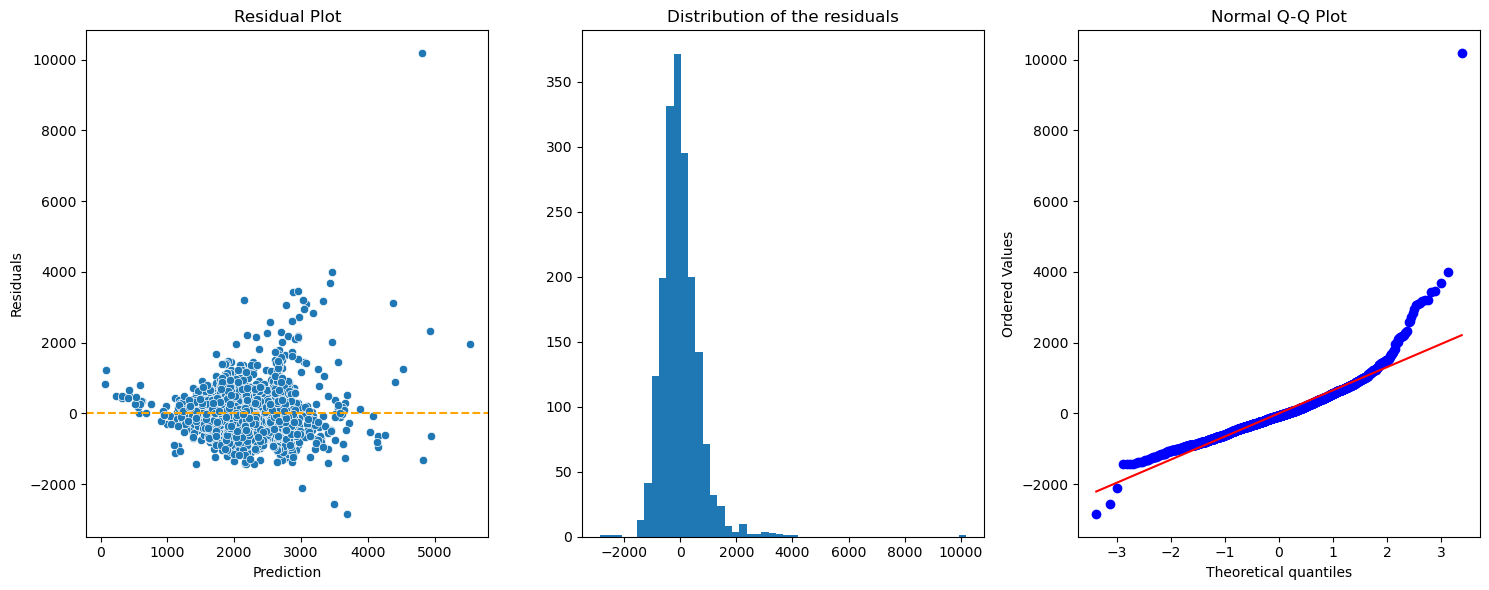

In [45]:
# Plot residuals
y_pred = base_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

**Observations**

The R-squared is 0.343, which indicates that 34.3% of the variance of the price is explained by the model, which suggests a poor fit.
Compared to the mean values, the MAE and RMSE are pretty high, which indicates our model doesn't perform really well.

The Durbin-Watson score of 1.982 indicates that the errors and independent. However, based on the residual plots, there's a big outlier with a residual of 10000. Other than that, the residuals are almost symmetrical.

When we look at the intercept and coefficients, they are statistically significant and they are all make sense.

### 1.2 Model refinement

In [47]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Train model
X_train_scaled_constant = sm.add_constant(X_train_scaled)
X_test_scaled_constant = sm.add_constant(X_test_scaled)
base_model_scaled = sm.OLS(y_train, X_train_scaled_constant).fit()

In [51]:
# Evaluate model
get_summary(base_model_scaled, X_test_scaled_constant, y_test)

,Metric,Value
0,R-squared,0.3430
1,Durbin-Watson,1.9820
2,MAE,487.4052
3,MSE,490729.9076
4,RMSE,700.5212
5,Test Mean,2168.5361
6,Predictions Mean,2166.9131
7,RMSE to test mean ratio,0.3230


**Observations**

Scaling the data doesn't make any difference in the performance of the model.

In [53]:
# Drop outliers
y_pred = base_model.predict(X_test_constant)
residuals = y_test - y_pred
pos_outliers = set(residuals[residuals > 3500].index)

while len(pos_outliers) > 0:
    df = df.drop(pos_outliers).reset_index(drop=True)
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=54)
    X_train_constant = sm.add_constant(X_train)
    X_test_constant = sm.add_constant(X_test)

    base_model = sm.OLS(y_train, X_train_constant).fit()
    y_pred = base_model.predict(X_test_constant)
    residuals = y_test - y_pred
    pos_outliers = set(residuals[residuals > 3500].index)

In [55]:
# Evaluate model
get_summary(base_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.3540
1,Durbin-Watson,1.9840
2,MAE,476.3262
3,MSE,406294.7138
4,RMSE,637.4125
5,Test Mean,2161.6537
6,Predictions Mean,2157.8427
7,RMSE to test mean ratio,0.2949


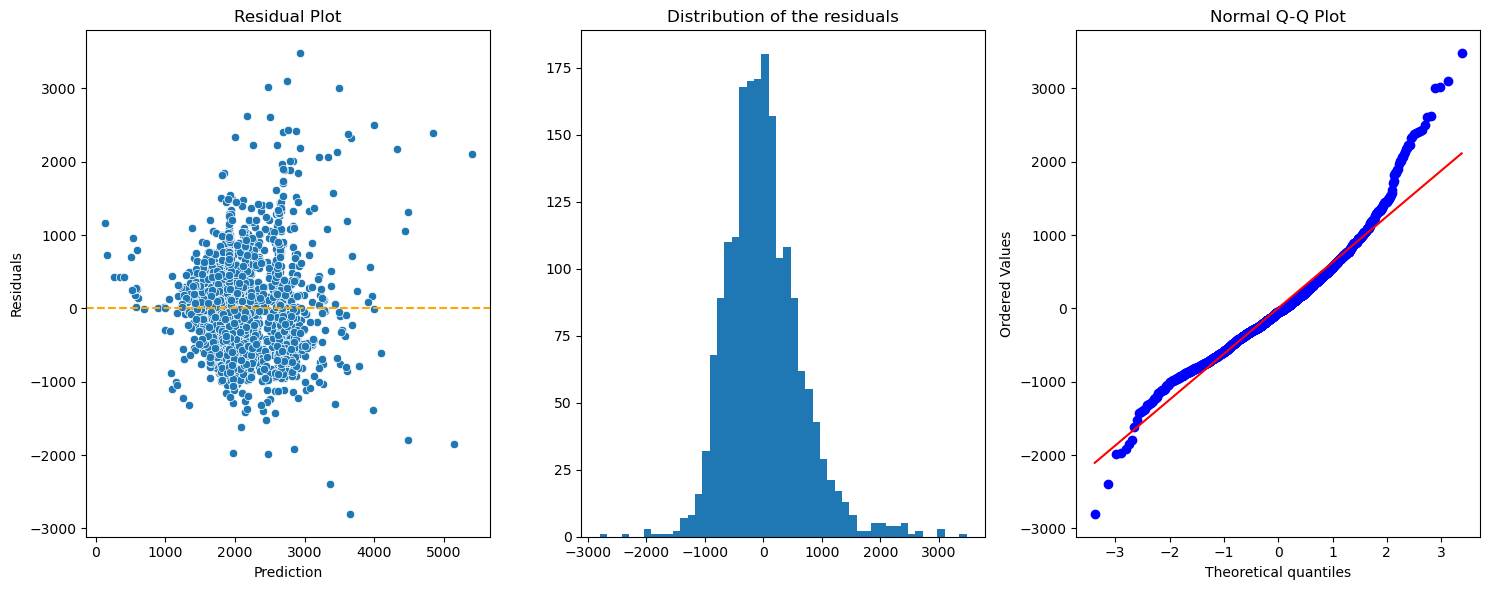

In [59]:
# Plot residuals
y_pred = base_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

By removing the outliers, the model has improved a little bit in terms of R-squared (0.343 to 0.354) and the RMSE went from 700.5212 to 637.4125. The tails of the Q-Q Plot indicates there might be a non-linear relationship between variables.

---

## 2. Transforming the target variable

In [62]:
# Transform into log
log_y = np.log(y)

In [64]:
# Train-test split
X_train, X_test, log_y_train, log_y_test = train_test_split(X, log_y, test_size=0.1, random_state=54)

In [66]:
# Train model
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)
model_log = sm.OLS(log_y_train, X_train_constant).fit()

In [68]:
# Evaluate model
get_summary(model_log, X_test_constant, log_y_test)

,Metric,Value
0,R-squared,0.3280
1,Durbin-Watson,1.9850
2,MAE,0.2338
3,MSE,0.1559
4,RMSE,0.3949
5,Test Mean,7.6002
6,Predictions Mean,7.6011
7,RMSE to test mean ratio,0.0520


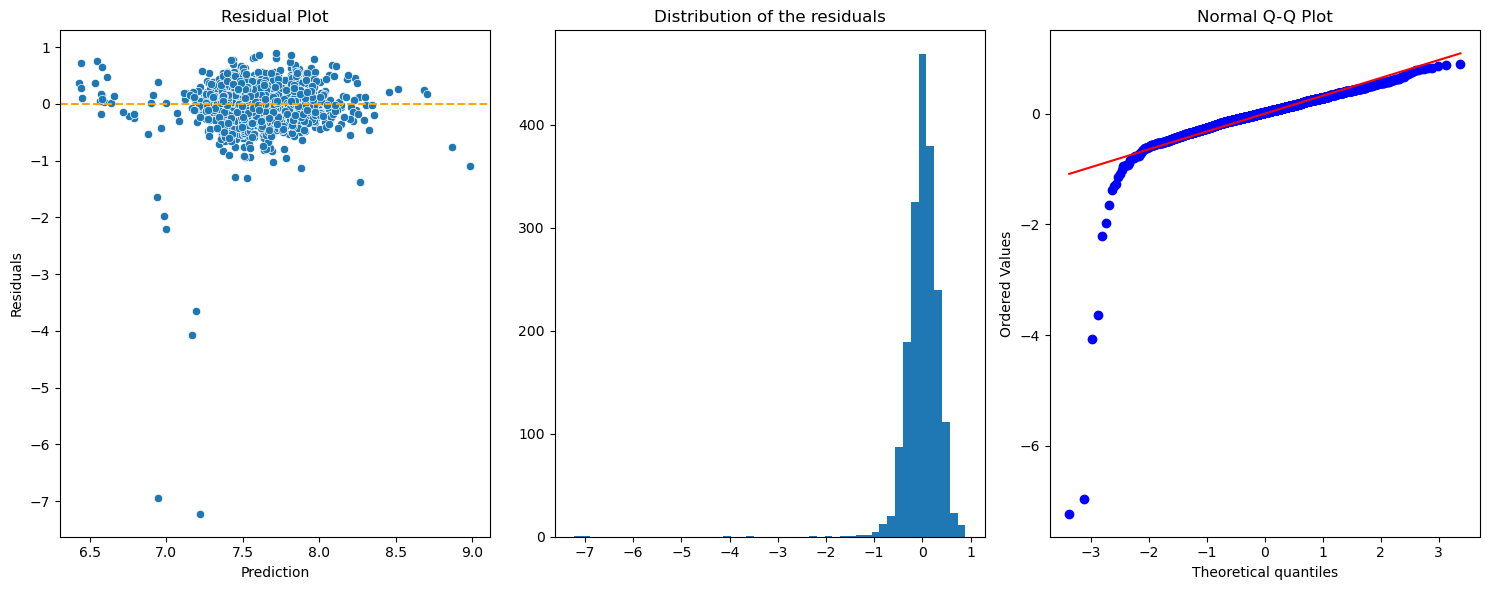

In [70]:
# Plot residuals
log_y_pred = model_log.predict(X_test_constant)
plot_residuals(log_y_test, log_y_pred)

The R-squared has decreased a little bit (0.353 to 0.3280) but the relative RMSE has decreased. If we look at left tail of the the Q-Q plot, there seems to be outliers.

In [72]:
# Drop outliers
log_y_pred = model_log.predict(X_test_constant)
residuals = log_y_test - log_y_pred
pos_outliers = set(residuals[np.abs(residuals) > 1].index)

while len(pos_outliers) > 0:
    df = df.drop(pos_outliers).reset_index(drop=True)
    X = df.drop('price', axis=1)
    y = df['price']

    log_y = np.log(y)
    log_y = log_y.rename('log(price)')

    X_train, X_test, log_y_train, log_y_test = train_test_split(X, log_y, test_size=0.1, random_state=54)
    X_train_constant = sm.add_constant(X_train)
    X_test_constant = sm.add_constant(X_test)

    model_log = sm.OLS(log_y_train, X_train_constant).fit()
    log_y_pred = model_log.predict(X_test_constant)
    residuals = log_y_test - log_y_pred
    pos_outliers = set(residuals[np.abs(residuals) > 1].index)

In [74]:
# Evaluate model
get_summary(model_log, X_test_constant, log_y_test)

,Metric,Value
0,R-squared,0.3900
1,Durbin-Watson,1.9930
2,MAE,0.2166
3,MSE,0.0771
4,RMSE,0.2776
5,Test Mean,7.6052
6,Predictions Mean,7.6052
7,RMSE to test mean ratio,0.0365


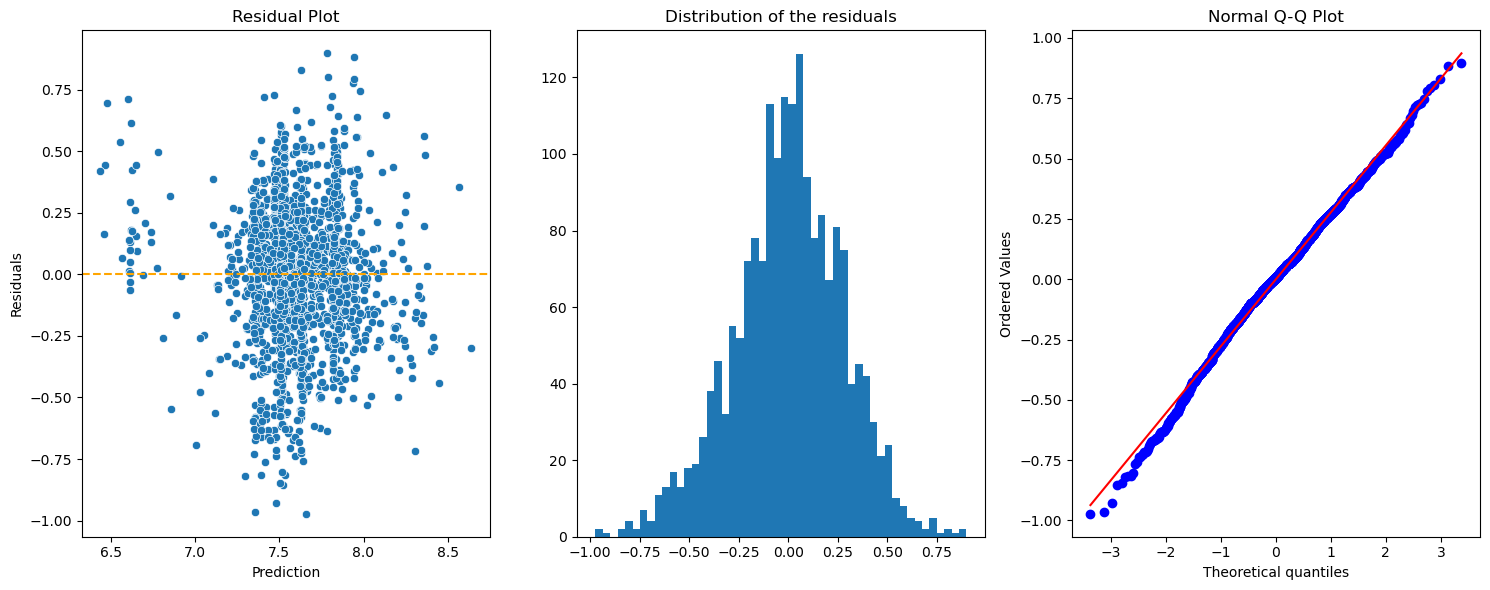

In [76]:
# Plot residuals
log_y_pred = model_log.predict(X_test_constant)
plot_residuals(log_y_test, log_y_pred)

By removing the outliers, the R-squared improved (0.3280 to 0.39) and the RMSE went from 0.3949 to 0.2776. The errors are almost normally distributed. The test mean and predictions mean are equal. This is our best performing model so far. Let's see if we can improve the performance by regularizing our model.

---

## 3. Regularization, cross-validation and grid search

In [78]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### 3.2 ElasticNet Grid Search

In [80]:
# Fit model
elastic_net_model = ElasticNet()

param_grid = {'alpha': [0.1, 1, 5, 10, 50, 100],
              'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

grid_model = GridSearchCV(estimator=elastic_net_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1)

grid_model.fit(X_train_scaled, log_y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [82]:
# Optimal alpha and l1_ratio values
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.1)

In [84]:
# Evaluate model
get_summary2(grid_model, X_test_scaled, log_y_test)

,Metric,Value
0,R-squared,0.4151
1,MAE,0.2171
2,MSE,0.0786
3,RMSE,0.2804
4,Test Mean,7.6052
5,Predictions Mean,7.6046
6,RMSE to test mean ratio,0.0369


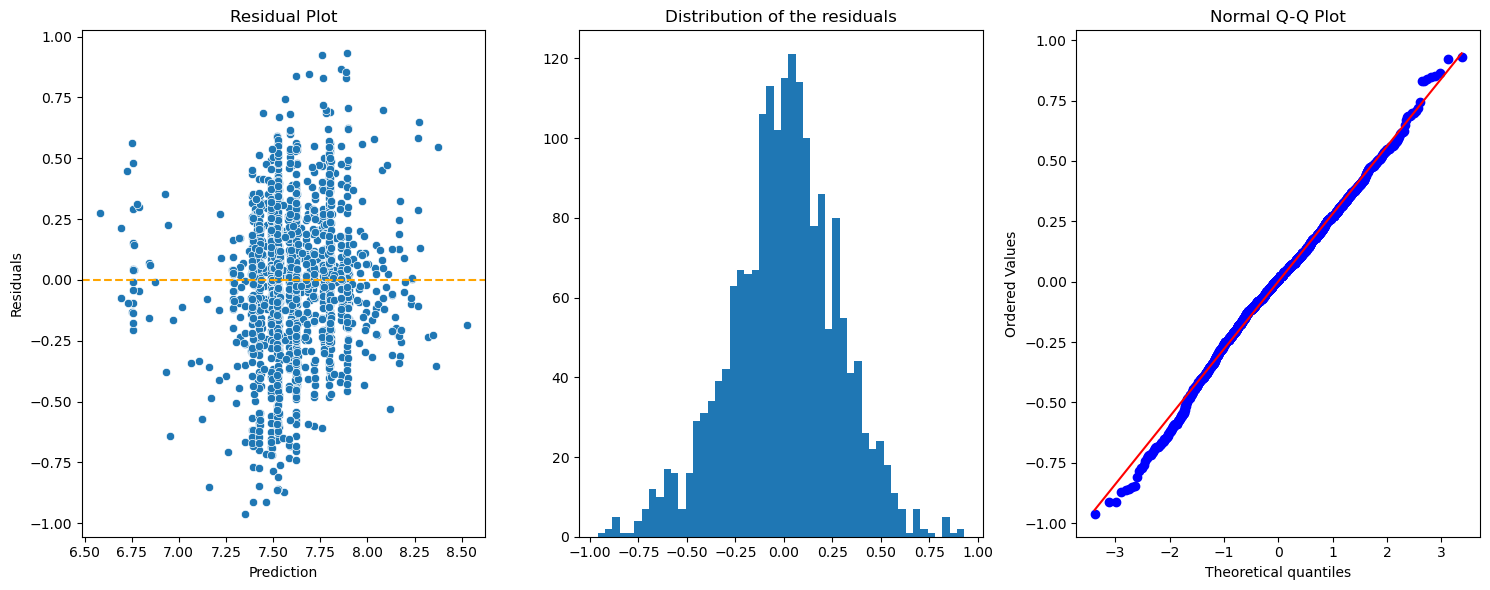

In [88]:
# Plot residuals
log_y_pred = grid_model.predict(X_test_scaled)
plot_residuals(log_y_test, log_y_pred)

The R-squared went from 0.39 to 0.4151 but the RMSE went from 0.2776 to 0.2804. The ElasticNet Grid Search didn't reslly improve the performance.

### 3.3 ElasticNet Cross Validation

In [92]:
# ElasticCV model
cv_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], eps=0.01, n_alphas=200, max_iter=10000)
cv_model.fit(X_train_scaled, log_y_train)

ElasticNetCV(eps=0.01, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000, n_alphas=200)

In [94]:
# l1 ratio comparison
print(f'ElasticNet CV L1 ratio: {cv_model.l1_ratio_}, \nElasticNet Grid Search L1 ratio: {grid_model.best_estimator_.l1_ratio}')

ElasticNet CV L1 ratio: 1.0, 
ElasticNet Grid Search L1 ratio: 0.1


In [96]:
# Evaluate model
get_summary2(cv_model, X_test_scaled, log_y_test)

,Metric,Value
0,R-squared,0.4262
1,MAE,0.2164
2,MSE,0.0771
3,RMSE,0.2777
4,Test Mean,7.6052
5,Predictions Mean,7.6051
6,RMSE to test mean ratio,0.0365


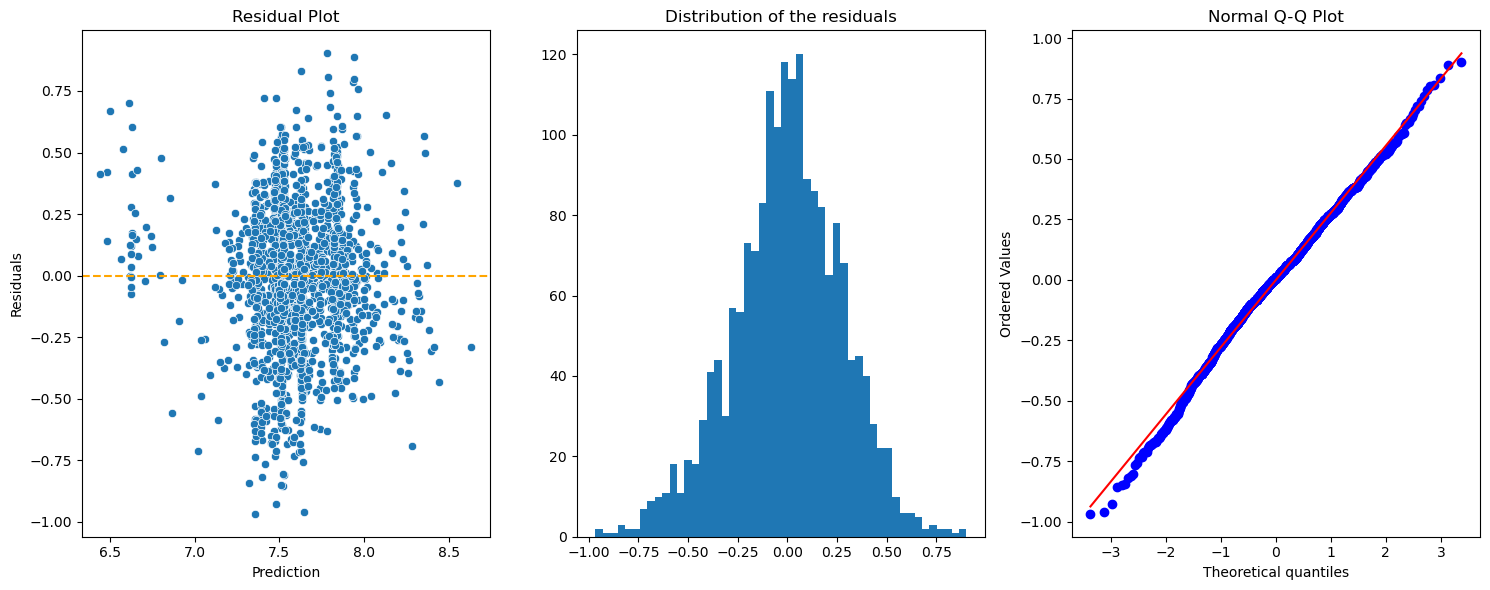

In [100]:
# Plot residuals
log_y_pred = cv_model.predict(X_test_scaled)
plot_residuals(log_y_test, log_y_pred)

The R-squared went from 0.4151 to 0.4262 and the RMSE went from 0.2804 to 0.2777. The Cross Validation performs a little bit better than the Grid Search. This is going to be our final model.

In [124]:
# Get intercept and coefficients
coefficients = get_coefficients2(cv_model, X_train_scaled)
coefficients

,coefficient
intercept,7.603772
beds,0.110584
baths,0.120113
sq_feet,0.001788
cats,-0.018746
dogs,0.037249
postal_code,0.014815
type_Apartment,0.068353
type_Basement,-0.027107
type_Room For Rent,-0.122888


In [223]:
# Assign model as final model
final_model = cv_model

---

## 4. Final Model

\begin{align}
\ln(y) = 7.603772 \\
&+ 0.110584(beds) \\
&+ 0.120113(baths) \\
&+ 0.001788(sqFeet) \\
&- 0.018746(cats) \\
&+ 0.037249(dogs) \\
&+ 0.014815(postalCode) \\
&+ 0.068353(typeAppartment) \\
&- 0.027107(typeBasement) \\
&- 0.122888(typeRoomForRent) \\
&- 0.040593(furnishingUnfurnished)
\end{align}

In [185]:
# Exponentiate the coefficients and calculate increase/decrease
print('beds:', f'{(np.exp(coefficients.loc['beds']).values[0] - 1):.2%}')
print('baths:', f'{(np.exp(coefficients.loc['baths']).values[0] - 1):.2%}')
print('sq_feet:', f'{(np.exp(coefficients.loc['sq_feet']).values[0] - 1):.2%}')
print('cats:', f'{(np.exp(coefficients.loc['cats']).values[0] - 1):.2%}')
print('dogs:', f'{(np.exp(coefficients.loc['dogs']).values[0] - 1):.2%}')
print('postal_code:', f'{(np.exp(coefficients.loc['postal_code']).values[0] - 1):.2%}')
print('type_Apartment:', f'{(np.exp(coefficients.loc['type_Apartment']).values[0] - 1):.2%}')
print('type_Basement:', f'{(np.exp(coefficients.loc['type_Basement']).values[0] - 1):.2%}')
print('type_Room For Rent:', f'{(np.exp(coefficients.loc['type_Room For Rent']).values[0] - 1):.2%}')
print('furnishing_Unfurnished:', f'{(np.exp(coefficients.loc['furnishing_Unfurnished']).values[0] - 1):.2%}')

beds: 11.69%
baths: 12.76%
sq_feet: 0.18%
cats: -1.86%
dogs: 3.80%
postal_code: 1.49%
type_Apartment: 7.07%
type_Basement: -2.67%
type_Room For Rent: -11.56%
furnishing_Unfurnished: -3.98%


### 4.1 Interpretation

**beds**<br>
A increase of one bedroom is associated with an 11.69% increase of the price.

**baths**<br>
A increase of one bathroom is associated with an 12.76% increase of the price.

**sq_feet**<br>
A increase of one square feet is associated with an 0.18% increase of the price.

**cats**<br>
The acceptal of cats is associated with a price decrease of 1.86%.

**dogs**<br>
The acceptal of dogs is associated with a price decrease of 3.80%.

**postal_code**<br>
A one unit increase of frequency of ads for a certain area is associated with a 1.49% price increase.

**type_Apartment**<br>
The rental being an apartment is associated with a 7.07% price increase.

**type_Basement**<br>
The rental being an basement is associated with a 2.67% price decrease.

**type_Room For Rent**<br>
The rental being an room is associated with a 11.56% price decrease.

**furnishing_Unfurnished**<br>
The rental being unfurnished is associated with a 3.98% price decrease.

### 4.2 Make Predictions

We'll estimate the price of [this 2 bedroom apartment in Montreal](https://www.rentfaster.ca/qc/montreal/rentals/apartment/1-bedroom/pet-friendly/395040?-RSYNC).

In [202]:
# Load data
with open('Data/postcode_frequencies.pkl', 'rb') as handle:
    pc_frequency_map = pickle.load(handle)

In [227]:
# Create X test matrix
data = {
    'beds': [2],
    'baths': [2],
    'sq_feet': [963],
    'cats': [1],
    'dogs': [1],
    'postal_code': [pc_frequency_map['H3V']],
    'type_Apartment': [1],
    'type_Basement': [0],
    'type_Room For Rent': [0],
    'furnishing_Unfurnished': [0]
}

array([7.96689525])

In [245]:
# Calculate price difference
y_test = 2225
X_test = pd.DataFrame(data)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
log_y_pred = final_model.predict(X_test_scaled)[0]
y_pred = np.exp(log_y_pred)
difference = np.abs(y_test - y_pred)
difference_ratio = np.abs((y_test - y_pred) / y_test)

print(f'The predicted price is ${y_pred:.2f} and the actual price is ${y_test:.2f}. \
\nWe are off by ${difference:.2f} ({difference_ratio:.2%}).')

The predicted price is $2883.89 and the actual price is $2225.00. 
We are off by $658.89 (29.61%).


In [252]:
# Dump model and scaler

joblib.dump(final_model, 'regression_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

## End